# Example 2: 2D Doughnuts

In this example we'll take a toy 2D PDF (two rings, with density decreasing with distance from ring) and draw samples from it.

## Python preamble

Imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import sys

Matplotlib style file

In [20]:
plt.style.use('figstyle.mplstyle')

Set up RNG (this is optional, but it makes results reproducible)

In [21]:
rng = np.random.default_rng(42)

## Toy model

We'll define a function that evaluates the PDF. The PDF will look like two rings, one centred at $(-2, -2)$ and the other at $(2, 2)$, both with unit radius. Density drops as $e^{-d^2}$ with distance $d$ from the ring. The implementation here is a little hacky, but functional. The function takes in an array of coordinates shaped (N, 2) and returns an array of densities shaped (N).

It's worth noting that the PDF evaluated here is actually not a true PDF, in the sense that we have chucked away any normalising constants. This turns out not to matter, we'll still get samples OK.

This is a _vectorized_ pdf as well, meaning that we can simultaneously ask for $N$ samples. We'll pass a flag to `LintSampler` below letting it know to take advantage of this optimisation.

In [22]:
def circles_pdf(x):
    c1 = np.array([-2.0, -2.0])
    r1 = 1.0
    c2 = np.array([2.0, 2.0])
    r2 = 1.0
    w = 0.4
    
    v1 = x - c1
    v2 = x - c2
    av1 = np.linalg.norm(v1, axis=-1)[:, None]
    av2 = np.linalg.norm(v2, axis=-1)[:, None]
    
    pt1 = np.zeros_like(x)
    pt2 = np.zeros_like(x)
    
    m1 = (av1 == 0).squeeze()
    m2 = (av2 == 0).squeeze()
    pt1[~m1] = c1 + r1 * v1[~m1] / av1[~m1]
    pt2[~m2] = c2 + r2 * v2[~m2] / av2[~m2]
    pt1[m1] = c1 + r1 * np.array([1.0, 0.0])
    pt2[m2] = c2 + r2 * np.array([1.0, 0.0])
    
    d1 = np.linalg.norm(x - pt1, axis=-1)
    d2 = np.linalg.norm(x - pt2, axis=-1)
    
    return np.exp(-0.5 * d1**2 / w**2) + np.exp(-0.5 * d2**2 / w**2)

Let's visualise this PDF:

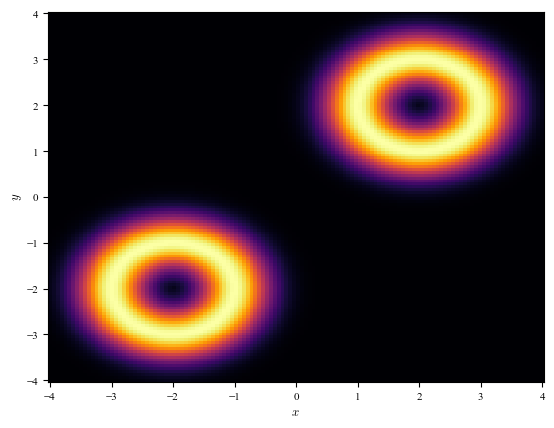

In [23]:
N_grid = 128
Xgrid, Ygrid = np.meshgrid(np.linspace(-4, 4, N_grid), np.linspace(-4, 4, N_grid), indexing='ij')
pos = np.stack((Xgrid, Ygrid), axis=-1).reshape((N_grid**2, 2))
plt.pcolormesh(Xgrid, Ygrid, circles_pdf(pos).reshape((N_grid, N_grid)), cmap='inferno')
plt.xlabel('$x$', usetex=True);
plt.ylabel('$y$', usetex=True);

## First approach: sampled on one grid

First, let's use `LintSampler` to draw samples from the PDF evaluated on a fixed $16\times 16$ grid (recall that the grid needn't be fixed, it can have unequal spacings) between $x=-4$ and $x=4$. First, import `LintSampler`:

In [24]:
from lintsampler import LintSampler

Set up the grid:

In [25]:
N_grid = 16
edges = np.linspace(-4, 4, N_grid + 1)

Initialise the `LintSampler` object and draw samples:

In [26]:
X = LintSampler((edges,edges),pdf=circles_pdf,seed=rng,vectorizedpdf=True).sample(N=10000000)

Visualise:

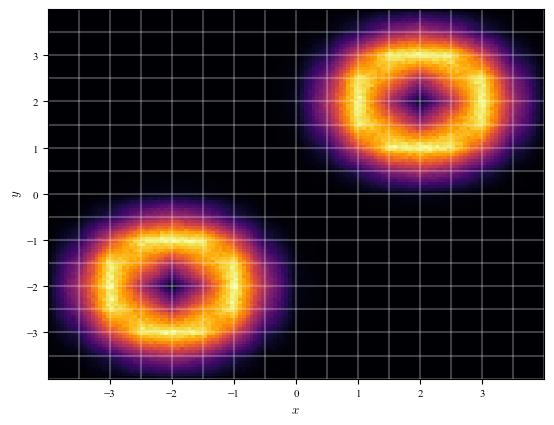

In [27]:
plt.hist2d(X[:, 0], X[:, 1], 128, cmap='inferno');
for edge in edges:
    plt.plot([edge, edge], [-4, 4], c='w', alpha=0.25)
    plt.plot([-4, 4], [edge, edge], c='w', alpha=0.25)
plt.xlabel('$x$', usetex=True);
plt.ylabel('$y$', usetex=True);

Seems to work well, but there are clear grid artifacts.

## Second approach: two separate grids

Using a single space-filling grid with is wasteful in situations like this one, where a lot of space has no mass (e.g., the top left and bottom right). Here we could instead have two $12 \times 12$ grids, one for each ring.

Set up two grids, with edges defined by `e0` and `e1`:

In [28]:
N_grid = 12
e0 = np.linspace(-4, 0, N_grid + 1)
e1 = np.linspace(0, 4, N_grid + 1)

Initialise `LintSampler` and draw samples:

In [29]:
samples = LintSampler([(e0,e0),(e1,e1)],pdf=circles_pdf,seed=rng,vectorizedpdf=True).sample(N=10000000)

Visualise:

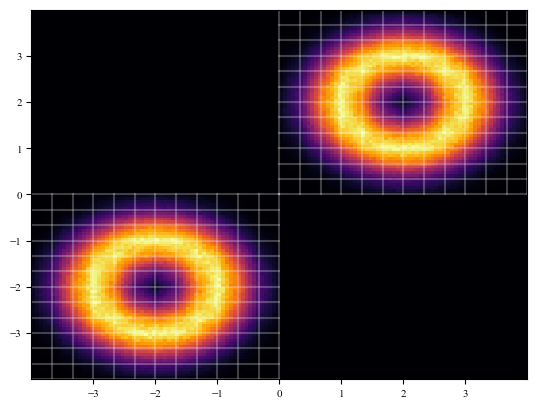

In [30]:
plt.hist2d(samples[:, 0], samples[:, 1], 128, cmap='inferno');
for edge in e0:
    plt.plot([edge, edge], [-4, 0], c='w', alpha=0.25)
    plt.plot([-4, 0], [edge, edge], c='w', alpha=0.25)
for edge in e1:
    plt.plot([edge, edge], [0, 4], c='w', alpha=0.25)
    plt.plot([0, 4], [edge, edge], c='w', alpha=0.25)

## Final checks

As in the first example, let's check that we can completely remove grid artifacts if we dial up the grid resolution.

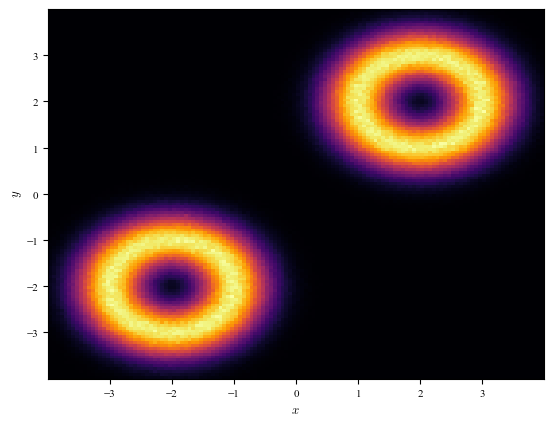

In [31]:
N_grid = 256
edges = np.linspace(-4, 4, N_grid + 1)

X = LintSampler((edges, edges), pdf=circles_pdf,seed=rng,vectorizedpdf=True).sample(N=10000000)

plt.hist2d(X[:, 0], X[:, 1], 128, cmap='inferno');
plt.xlabel('$x$', usetex=True);
plt.ylabel('$y$', usetex=True);